📌 **Automatyczna klasyfikacja rodzajów chmur**

## 🏆 Kamień Milowy 1: Zrozumienie problemu i eksploracja danych

Celem projektu jest stworzenie modelu do **automatycznej klasyfikacji rodzajów chmur** na podstawie obrazów. Może to znaleźć zastosowanie w wielu dziedzinach:

### 🌦️ **Potencjalne zastosowania:**
- **Prognozowanie pogody** ☁️  
  Automatyczna analiza chmur może wspierać modele predykcyjne, poprawiając dokładność krótkoterminowych prognoz pogody. Można np. wykrywać nadchodzące burze lub przewidywać opady deszczu na podstawie formacji chmur.
  
- **Analiza klimatu** 🌍  
  Długoterminowe monitorowanie typów chmur pozwala na analizę zmian klimatycznych. Może pomóc w badaniach nad wpływem zjawisk atmosferycznych na globalne ocieplenie i wzorce pogodowe.

- **Wsparcie działalności rolniczej** 🌱  
  Rolnicy mogą korzystać z systemów monitorujących zachmurzenie w celu optymalizacji nawadniania oraz zapobiegania skutkom ekstremalnych warunków pogodowych, takich jak susze czy ulewne deszcze.

- **Monitorowanie jakości powietrza** 🌫️  
  Analiza chmur może pomóc w wykrywaniu zanieczyszczeń powietrza i ich wpływu na atmosferę. Specyficzne rodzaje chmur mogą wskazywać na obecność pyłów, smogu czy związków chemicznych.

- **Lotnictwo i nawigacja** ✈️  
  Automatyczna klasyfikacja chmur może wspierać systemy lotnicze, pomagając pilotom i kontrolerom ruchu lotniczego w ocenie warunków atmosferycznych i potencjalnych zagrożeń.

- **Badania astronomiczne** 🔭  
  W astronomii monitorowanie zachmurzenia jest kluczowe dla obserwacji kosmosu. Automatyczna klasyfikacja chmur może pomóc w wyborze optymalnych warunków do prowadzenia badań oraz w sterowaniu teleskopami.

---

🎯 **Miary sukcesu:**
Aby ocenić skuteczność modelu klasyfikującego chmury, będziemy korzystać z następujących metryk:

- **Dokładność klasyfikacji (accuracy)** 🎯  
  Sprawdza, jaka część wszystkich przewidywań jest poprawna. Jest to podstawowa metryka, ale w przypadku niezbalansowanych danych może być myląca.

- **Precyzja (precision)** 🎯  
  Wskazuje, jak wiele z przewidzianych przykładów danej klasy faktycznie do niej należy. Jest kluczowa, gdy zależy nam na minimalizacji fałszywych alarmów (np. błędnej klasyfikacji chmur deszczowych jako bezchmurnego nieba).

- **Pełność (recall)** 📢  
  Mierzy, jak wiele z rzeczywistych przykładów danej klasy zostało poprawnie wykrytych. Jest istotna np. przy wykrywaniu niebezpiecznych zjawisk pogodowych – lepiej wykryć wszystkie przypadki niż przegapić istotne.

- **F1-score** ⚖️  
  To połączenie precyzji i pełności – kluczowe w przypadku nierównomiernie reprezentowanych klas, ponieważ uwzględnia zarówno błędne pozytywne, jak i błędne negatywne klasyfikacje.

- **Macierz błędów (confusion matrix)** 🔎  
  Pozwoli szczegółowo przeanalizować, które klasy są najczęściej ze sobą mylone. Może to wskazać np., że model ma trudności z odróżnianiem chmur „Cloudy” od „Rainy”, co mogłoby wymagać dodatkowych danych lub innej reprezentacji cech.

---

📌 **Podsumowanie:**  
Dzięki temu podejściu możemy nie tylko stworzyć skuteczny model klasyfikacyjny, ale także zidentyfikować jego słabe strony i potencjalne ulepszenia. W kolejnych etapach skupimy się na poprawie jakości predykcji oraz na testowaniu różnych architektur modeli. 🚀


In [5]:
import tensorflow as tf
import os
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd

from IPython.core.display import display, HTML
display(HTML("<style>.output_scroll { height: auto; }</style>"))



## 🔍 Eksploracja i analiza danych
Zbiory danych znajdują się w katalogach:

In [2]:
train_dir = "cloud_dataset/train"
test_dir = "cloud_dataset/test"
val_dir = "cloud_dataset/val"

img_width, img_heigth = 150, 150
batch_size = 32

## 📸 Przykładowe obrazy w zbiorze treningowym

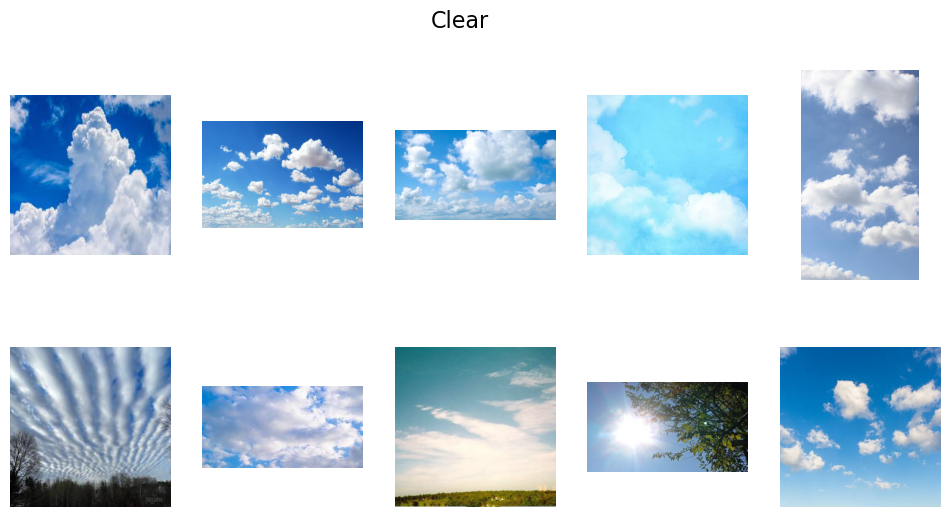

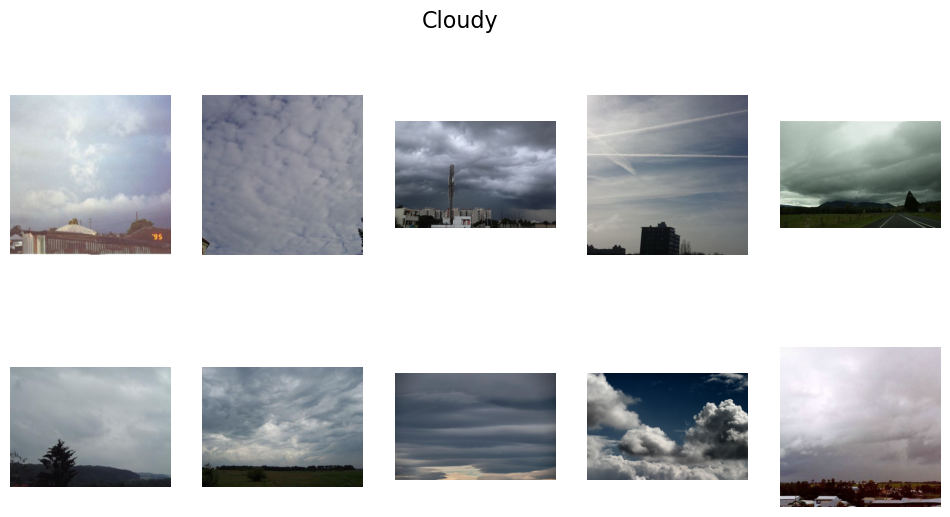

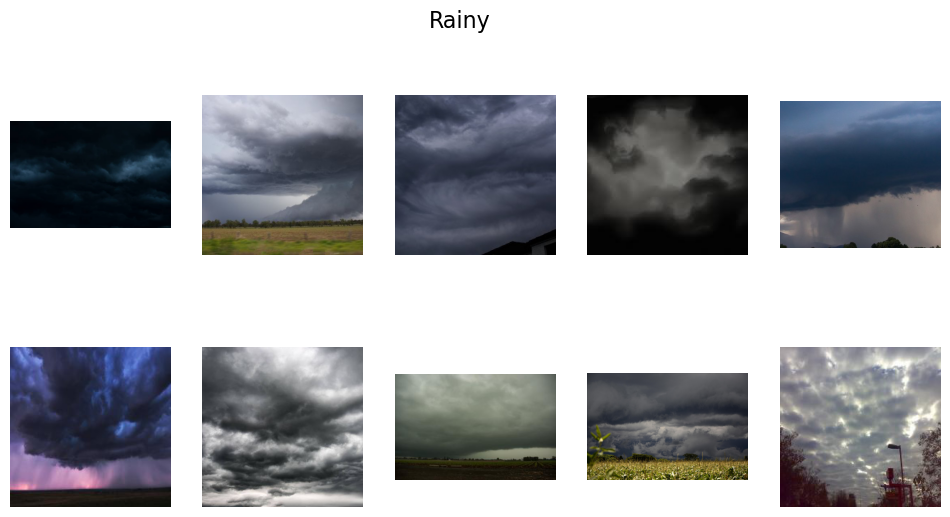

In [10]:
import random
def show_sample_images(directory, class_name, num_images=10):
    sample_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                sample_files.append(os.path.join(root, file))
    random.shuffle(sample_files)
    
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"{class_name}", fontsize=16)
    for i in range(min(num_images, len(sample_files))):
        img = Image.open(sample_files[i])
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.show()

show_sample_images(train_dir+"/Clear", "Clear")
show_sample_images(train_dir+"/Cloudy", "Cloudy")
show_sample_images(train_dir+"/Rainy", "Rainy")

    

### 🔍 Kluczowe obserwacje:
Podczas eksploracji danych zauważono, że:
- Obrazy w klasie **Clear** są wyraźnie różne od pozostałych, cechują się niebem bez chmur. ☀️
- Klasy **Cloudy** i **Rainy** są wizualnie podobne, co może powodować trudności w klasyfikacji. 🌫️🌧️
- Niektóre obrazy w klasie **Rainy** mogą przypominać te z **Cloudy**, zwłaszcza gdy deszcz nie jest dobrze widoczny.

## 📊 Analiza ilościowa danych

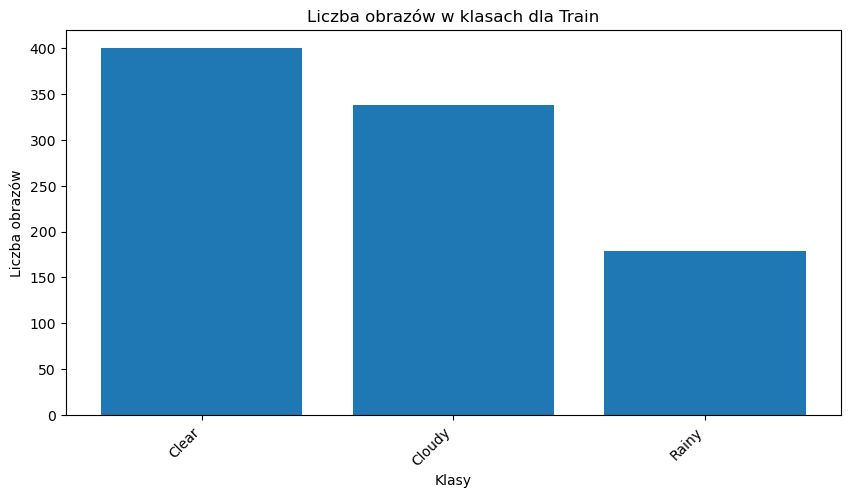

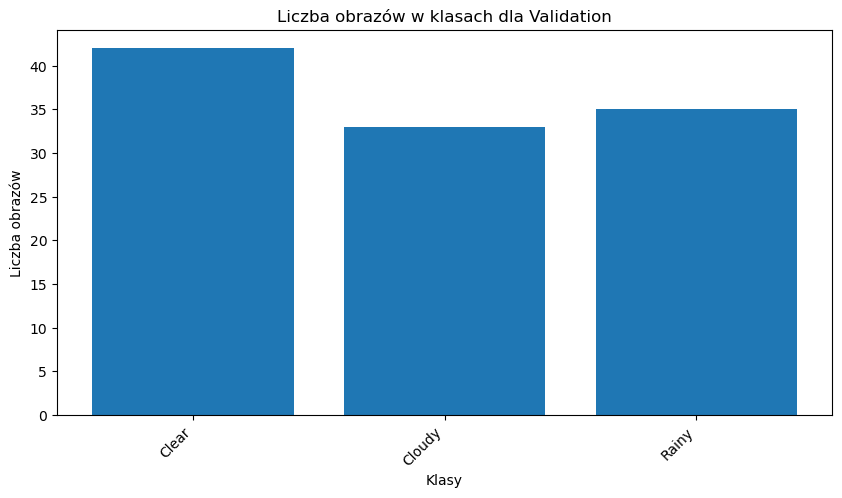

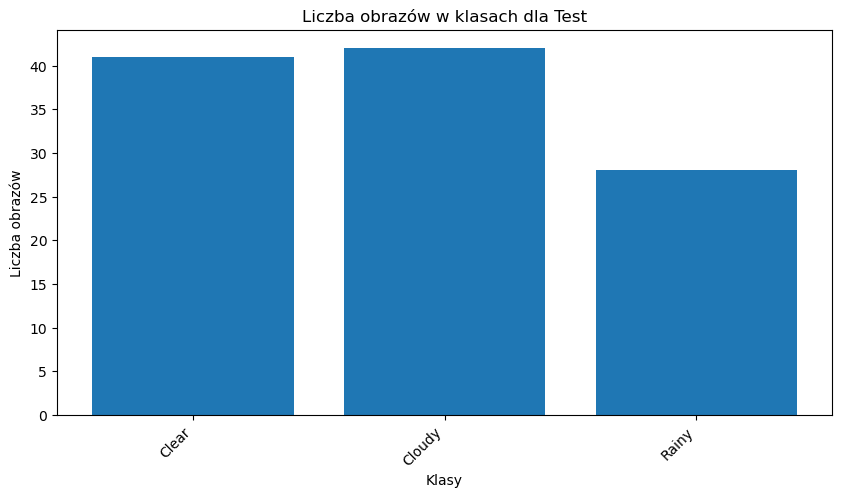

In [9]:
def analyze_and_plot(directory, dataset_name):
    classes = []
    image_counts = []
    
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):  # Sprawdzamy, czy to folder
            num_images = len(os.listdir(class_dir))
            classes.append(class_name)
            image_counts.append(num_images)
    
    # Tworzenie wykresu słupkowego
    plt.figure(figsize=(10, 5))
    plt.bar(classes, image_counts)
    plt.xlabel("Klasy")
    plt.ylabel("Liczba obrazów")
    plt.title(f"Liczba obrazów w klasach dla {dataset_name}")
    plt.xticks(rotation=45, ha='right')
    plt.show()

analyze_and_plot(train_dir, "Train")
analyze_and_plot(val_dir, "Validation")
analyze_and_plot(test_dir, "Test")


### 🔍 Nierównomierny rozkład klas
Analiza wykresów liczności klas w zbiorach danych ujawnia, że **procentowy udział każdej z klas różni się między zbiorami Train, Validation i Test**. Może to stanowić wyzwanie dla modelu, ponieważ nie będzie on uczony na danych o równomiernym rozkładzie, co może wpłynąć na jego zdolność do uogólniania predykcji.

###  **Dlaczego to problem?**
- **Nieproporcjonalna reprezentacja klas**:  
  W zbiorze treningowym klasy nie są równomiernie rozłożone – jedna z nich występuje znacznie częściej niż inne. Może to prowadzić do sytuacji, w której model będzie faworyzował najliczniejszą klasę, kosztem rzadziej występujących.
- **Różne rozkłady w zbiorach treningowym i testowym**:  
  Jeśli model uczy się na zbiorze, w którym jeden typ chmur dominuje, a następnie zostanie przetestowany na zbiorze o innym rozkładzie, może dojść do błędów klasyfikacji. Model może nie być dostatecznie dobrze dostosowany do rzeczywistych danych.
- **Trudność w klasyfikacji rzadziej występujących klas**:  
  Klasa z najmniejszą liczbą przykładów może być gorzej rozpoznawana, ponieważ model nie dostaje wystarczająco dużo próbek, by nauczyć się jej cech charakterystycznych.


# 🚨 Wykrywanie anomalii


In [13]:
def check_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()
        return True
    except Exception as e:
        print(f"Uszkodzony obraz {file_path}, błąd {e}")
        return False
def check_rgb(file_path):
    img = Image.open(file_path)
    if img.mode != "RGB":
        # print(file_path)
        # img = img.convert("RGB")
        # img.save(file_path)
        # os.remove(file_path)
        return False
    return True

count_bad = 0
count_not_rgb = 0
for root, dir, files in os.walk(train_dir):
    for file in files:
        file_path = os.path.join(root, file)
        if not check_image(file_path):
            count_bad += 1
        if not check_rgb(file_path):
            count_not_rgb += 1
            
print("tyle obrazow jest zlych: ", count_bad)
print("Byl 1 nie w rgb i zostal usuniety")
print("tyle obrazow nie jest w rgb: ", count_not_rgb)

tyle obrazow jest zlych:  0
Byl 1 nie w rgb i zostal usuniety
tyle obrazow nie jest w rgb:  1


In [21]:
def is_valid(image):
    width, height = image.size[0], image.size[1]
    return width > 100 and width < 700 and height > 100 and height < 550

valid_images = []
classes = []

for root, dir, files in os.walk(train_dir):
    for file in files:
        file_path = os.path.join(root, file)
        with Image.open(file_path) as img:
            if is_valid(img):
                valid_images.append(file_path)
                classes.append(os.path.basename(root))

df = pd.DataFrame({'filename': valid_images, 'class': classes})

###  **Mamy naprzykład taki obraz ktory zdecydowanie nie jest rzeczywistym zdjęciem chmury**

![Mamy naprzykład taki obraz ktory zdecydowanie nie jest rzeczywistym zdjęciem chmury](raw_cloud_dataset\train\Rainy\original_size_img_77_jpg.rf.c3154c897671512abd8b90ebdb1b377c.jpg)


# 🛠️ Wstępne przetwarzanie danych


### 🎨 **1. Przekształcanie i normalizacja obrazów**

In [22]:
validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
train_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = df,
    x_col = "filename",
    y_col = "class",
    target_size = (img_width, img_heigth),
    batch_size = batch_size,
    class_mode = "categorical"
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size = (img_width, img_heigth),
    batch_size = batch_size,
    class_mode = "categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_width, img_heigth),
    batch_size = batch_size,
    class_mode = "categorical"
)

Found 858 validated image filenames belonging to 3 classes.
Found 110 images belonging to 3 classes.
Found 111 images belonging to 3 classes.


### 🔍 **2. Augmentacja danych**

Found 858 validated image filenames belonging to 3 classes.


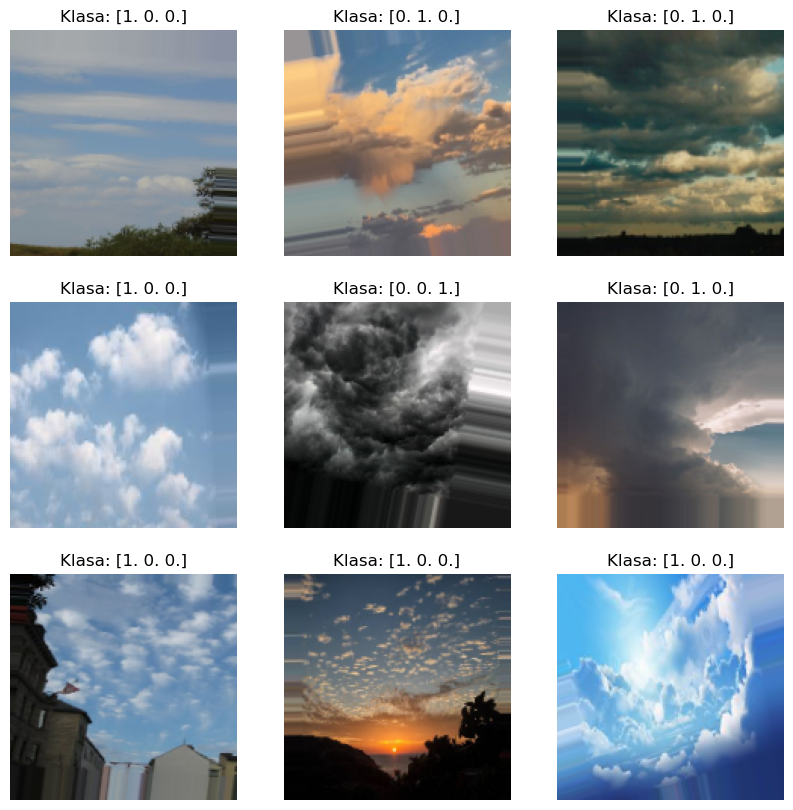

In [24]:
train_augmented_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest"
)

train_augmented_generator = train_augmented_datagen.flow_from_dataframe(
    dataframe = df,
    x_col = "filename",
    y_col = "class",
    target_size = (img_width, img_heigth),
    batch_size = batch_size,
    class_mode = "categorical"
)


images, labels = next(train_augmented_generator)

images, labels = next(train_augmented_generator)

plt.figure(figsize=(10, 10))
for i in range(9):  # Wyświetl 9 obrazów
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Klasa: {labels[i]}")
    plt.axis("off")

plt.show()



### 📌 Podsumowanie
Wykonano eksplorację i wstępną analizę zbioru danych. Zidentyfikowano liczność obrazów dla poszczególnych klas i sprawdzono przykładowe obrazy. W kolejnym kroku przygotujemy model do klasyfikacji chmur.